# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 29.11.2023

Мягий дедлайн: 23:59 12.12.2023

Жестокий дедлайн: 23:59 14.12.2023

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/56884/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ 10 (0.5 бонус)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [5]:
%load_ext autoreload
%autoreload 2
from hw5code import find_best_split, DecisionTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0 )
]

In [8]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

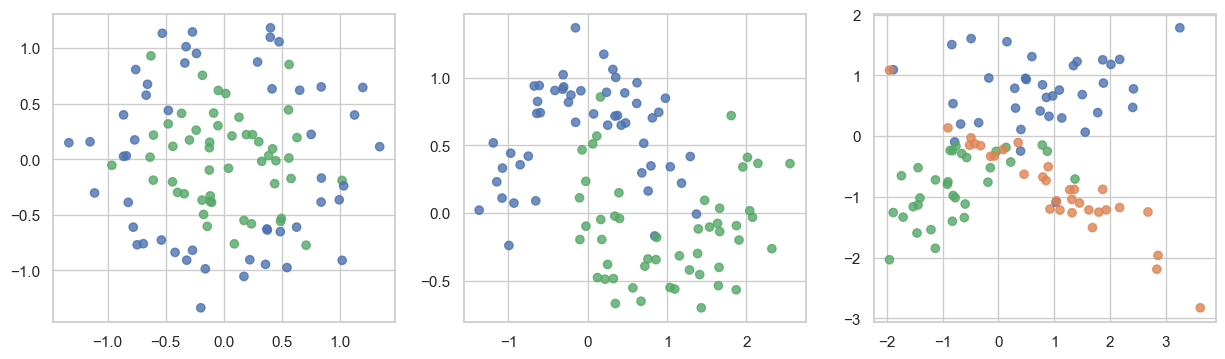

In [18]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [19]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

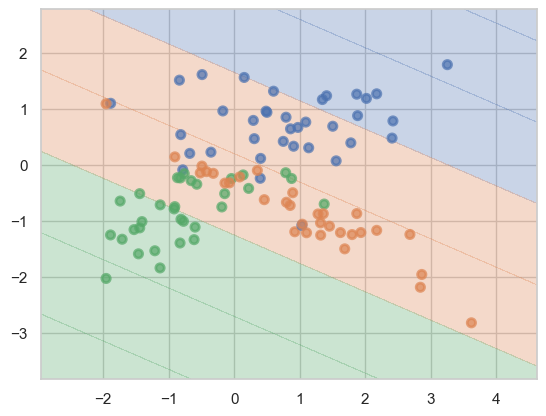

In [20]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

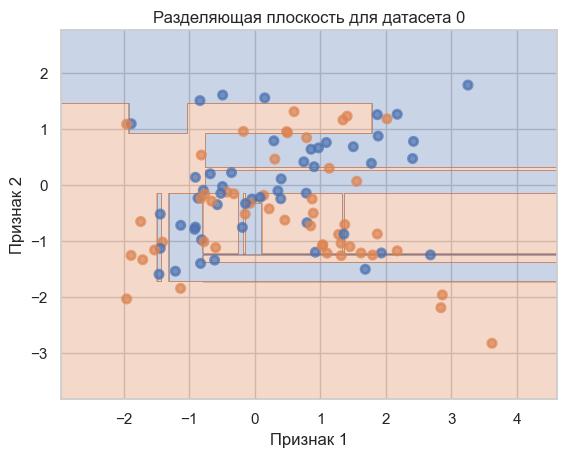

accurancy for train: 1.0
accurancy for test: 0.5666666666666667


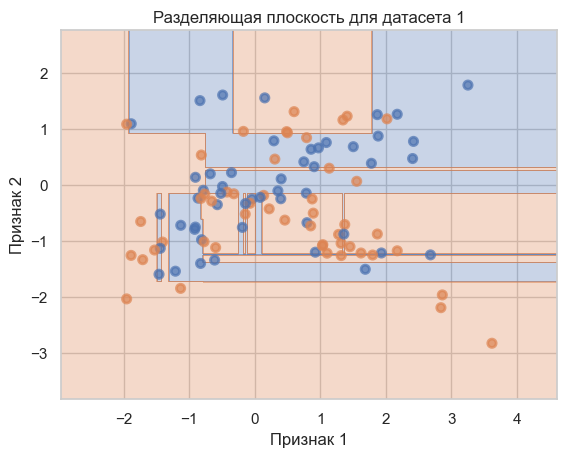

accurancy for train: 1.0
accurancy for test: 0.5


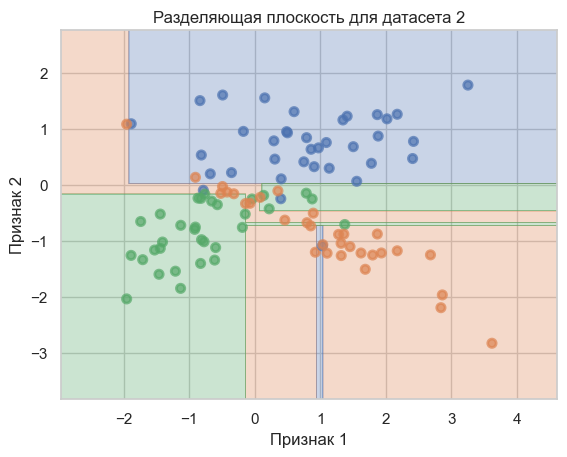

accurancy for train: 1.0
accurancy for test: 0.8


In [24]:
def get_accurancy(model, X, y):
    y_pred = model.predict(X)
    return (pd.Series(y_pred) == pd.Series(y)).sum() / y.shape[0]

for i, (x, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = DecisionTreeClassifier().fit(X_train, y_train)
    plot_surface(model, X, y)
    get_accurancy(model, X_test, y_test)
    plt.title(f'Разделяющая плоскость для датасета {i}')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.show()
    print('accurancy for train:', get_accurancy(model, X_train, y_train))
    print('accurancy for test:', get_accurancy(model, X_test, y_test))

__Ответ:__ судя по графикам, можно сделать вывод, что скорее всего присутствует переобучение

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

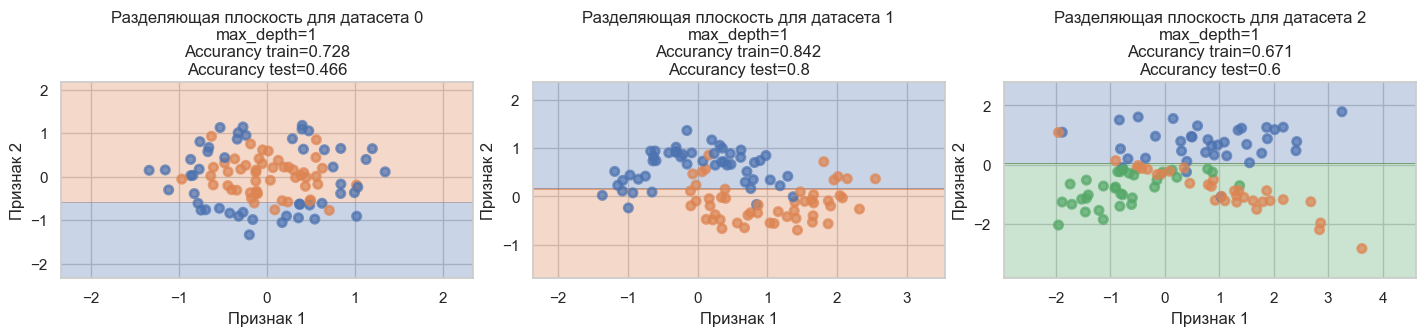

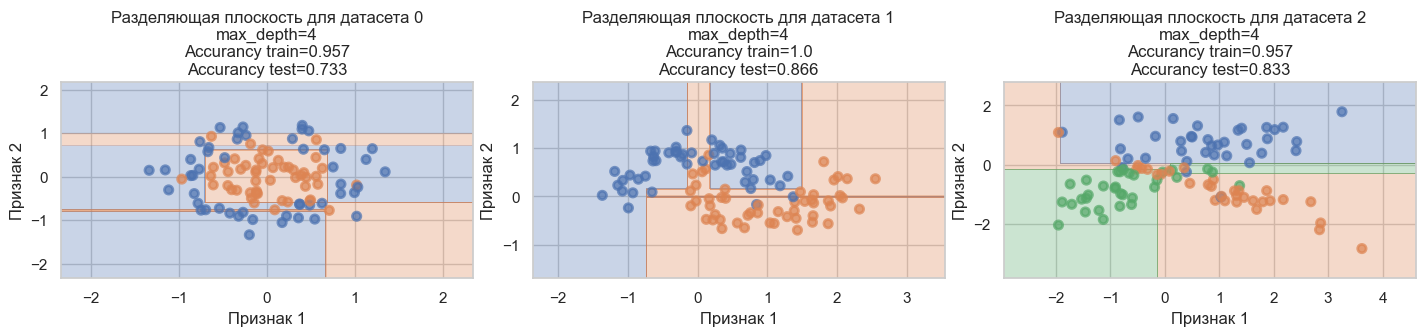

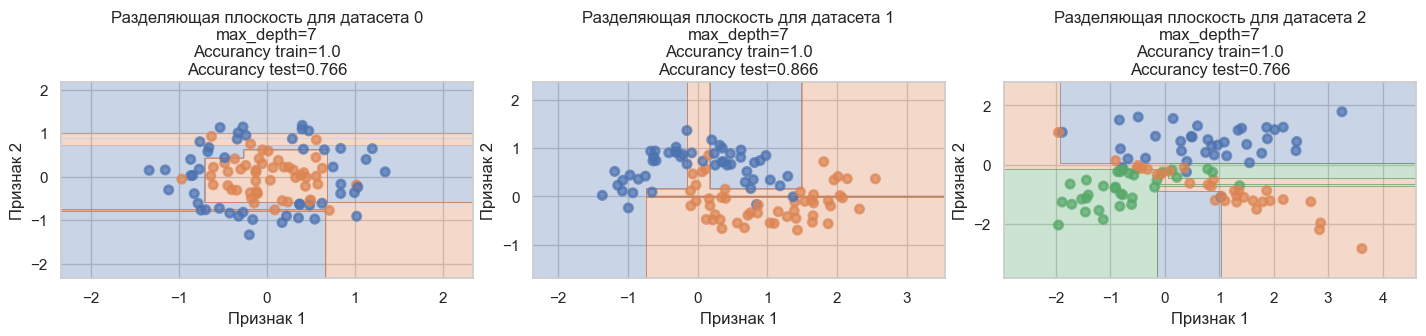

In [25]:
for max_depth in range(1, 10, 3):
    plt.figure(figsize=(15,4))
    for i, (x, y) in enumerate(datasets):
        plt.subplot(1, 3, i + 1)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
        model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
        plot_surface(model, x, y)
        get_accurancy(model, X_test, y_test)
        plt.title(f'Разделяющая плоскость для датасета {i}\n'
                  f'max_depth={max_depth}\n'
                  f'Accurancy train={str(get_accurancy(model, X_train, y_train))[0:5]}\n'
                  f'Accurancy test={str(get_accurancy(model, X_test, y_test))[0:5]}')
        plt.xlabel('Признак 1')
        plt.ylabel('Признак 2')
plt.show()

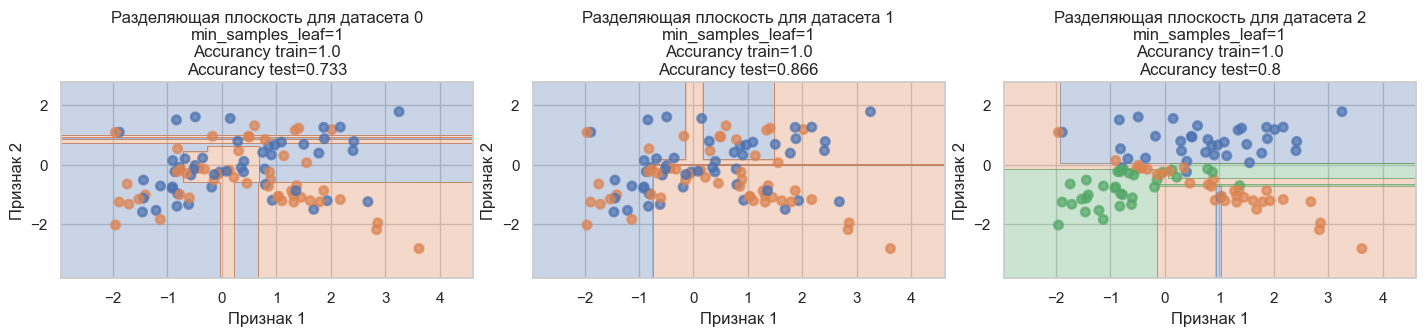

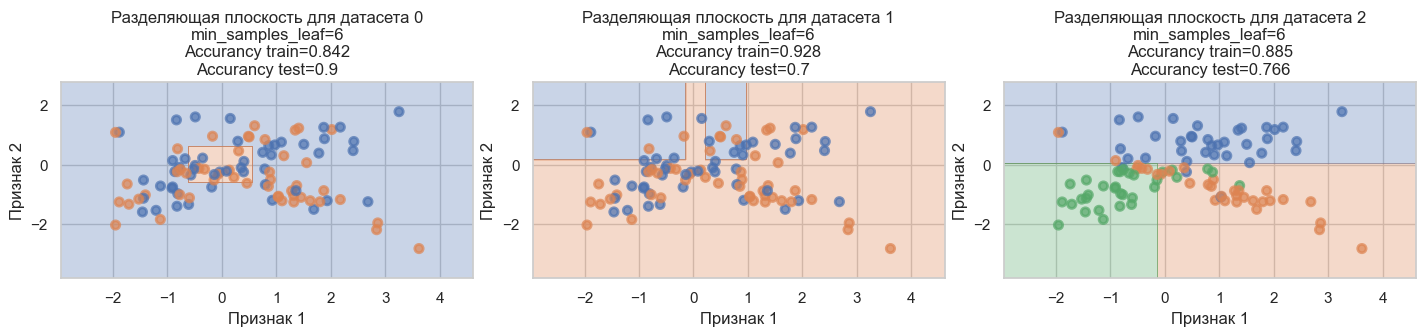

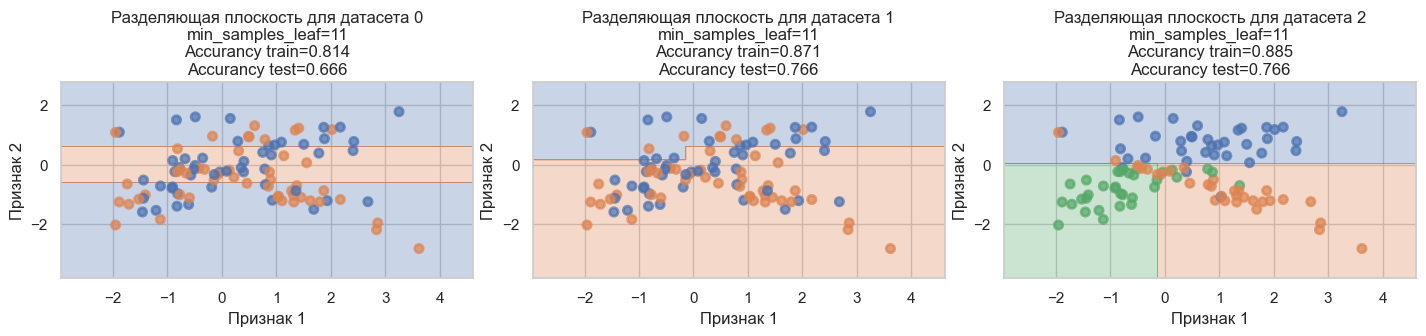

In [27]:
for min_samples_leaf in range(1, 16, 5):
    plt.figure(figsize=(15, 4))
    for i, (x, y) in enumerate(datasets):
        plt.subplot(1, 3, i + 1)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
        model = DecisionTreeClassifier(
            min_samples_leaf=min_samples_leaf
        ).fit(X_train, y_train)
        plot_surface(model, X, y)
        get_accurancy(model, X_test, y_test)
        plt.title(f'Разделяющая плоскость для датасета {i}\n'
                  f'min_samples_leaf={min_samples_leaf}\n'
                  f'Accurancy train={str(get_accurancy(model, X_train, y_train))[0:5]}\n'
                  f'Accurancy test={str(get_accurancy(model, X_test, y_test))[0:5]}')
        plt.xlabel('Признак 1')
        plt.ylabel('Признак 2')
plt.show()

__Ответ:__ чем больше глубина дерева, тем больше вершин в дереве, соответственно выборка будет разделена более точно. Исходя из графиков, чем больше __max_depth__, тем лучше качество на __train__.

Минимальное кол-во выборок в листе, критерий остановки, чем он меньше, тем больше гарантии на то, что в вершине объекты одного класса.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

https://contest.yandex.ru/contest/56884/run-report/102711622/

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

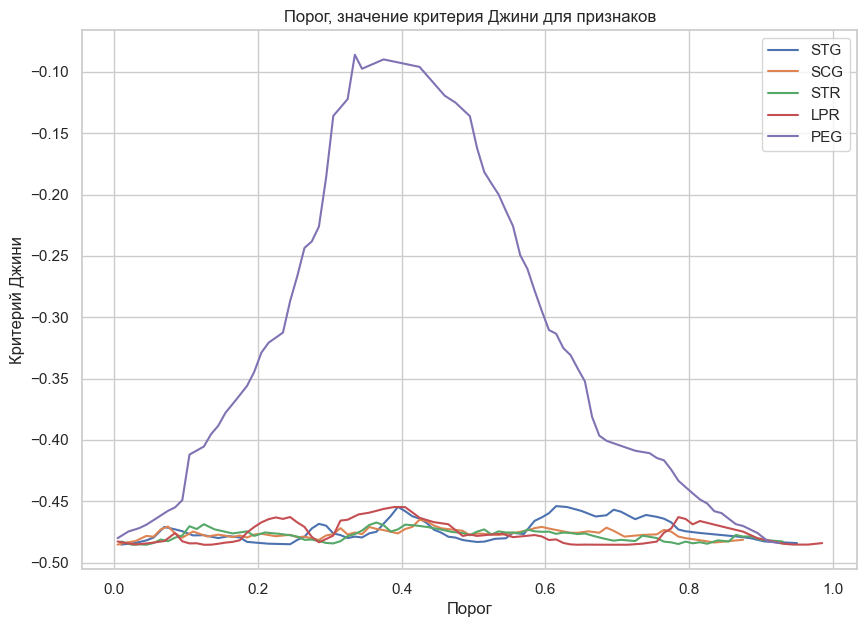

In [3]:
from hw5code import find_best_split


students_data = pd.read_csv('students.csv')
plt.figure(figsize=(10, 7))
for feature_name in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
    threasholds, ginis, best_threashold, best_gini = find_best_split(
        students_data[feature_name].to_numpy(), students_data['UNS'].to_numpy()
    )
    plt.plot(threasholds, ginis, label=feature_name)
plt.title(f'Порог, значение критерия Джини для признаков')
plt.xlabel('Порог')
plt.ylabel('Критерий Джини')
plt.legend()
plt.show()


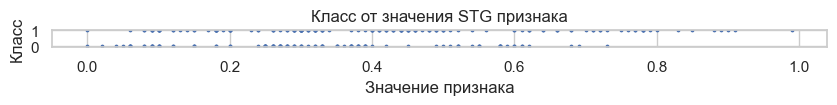

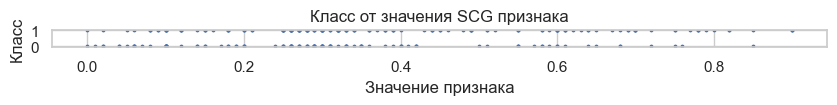

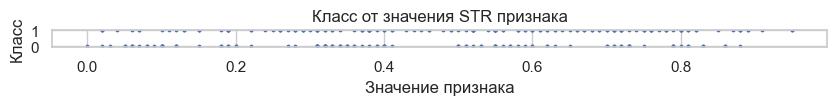

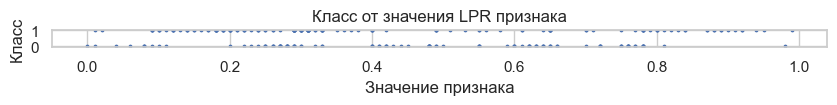

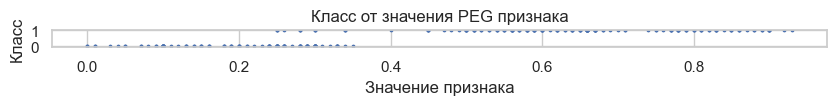

In [4]:
for feature_name in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
    plt.figure(figsize=(10, 0.23))
    plt.scatter(
        students_data[feature_name].to_numpy(), students_data['UNS'], s=3
    )
    plt.title(f'Класс от значения {feature_name} признака')
    plt.xlabel('Значение признака')
    plt.ylabel('Класс')
    plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
1) Нужно делить по критерию PEG.
2) Да, согласуются, так как значения PEG более разделимы.
3) Кривая положая на угол, то есть сначала всегда растет (идет к идеальному порогу, перебрасывая значения в другое множество чтобы при идеальном пороге было идиальное разбиение), потом всегда убывает. 
4) Они идут почти "параллельно" оси X, тоесть критерий Джини почти не улучшается. 

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [45]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data = pd.read_csv('agaricus-lepiota.data', header=None)

X = data.drop(columns=[0])
y = label_encoder.fit_transform(data[0].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=42)

for feature in X.columns:
    X_train[feature] = label_encoder.fit_transform(X_train[feature])
    X_test[feature] = label_encoder.transform(X_test[feature])

In [46]:
decision_tree = DecisionTree(['categorical'] * X.shape[1])
decision_tree.fit(X_train.values, y_train)

print(f"Accuracy:\n",
      f"\tTrain:\t{np.sum((decision_tree.predict(X_train.values) == y_train) * 1) / y_train.shape[0]}\n"
      f"\tTest:\t{np.sum((decision_tree.predict(X_test.values) == y_test) * 1) / y_test.shape[0]}"
     )

Accuracy:
 	Train:	1.0
	Test:	1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

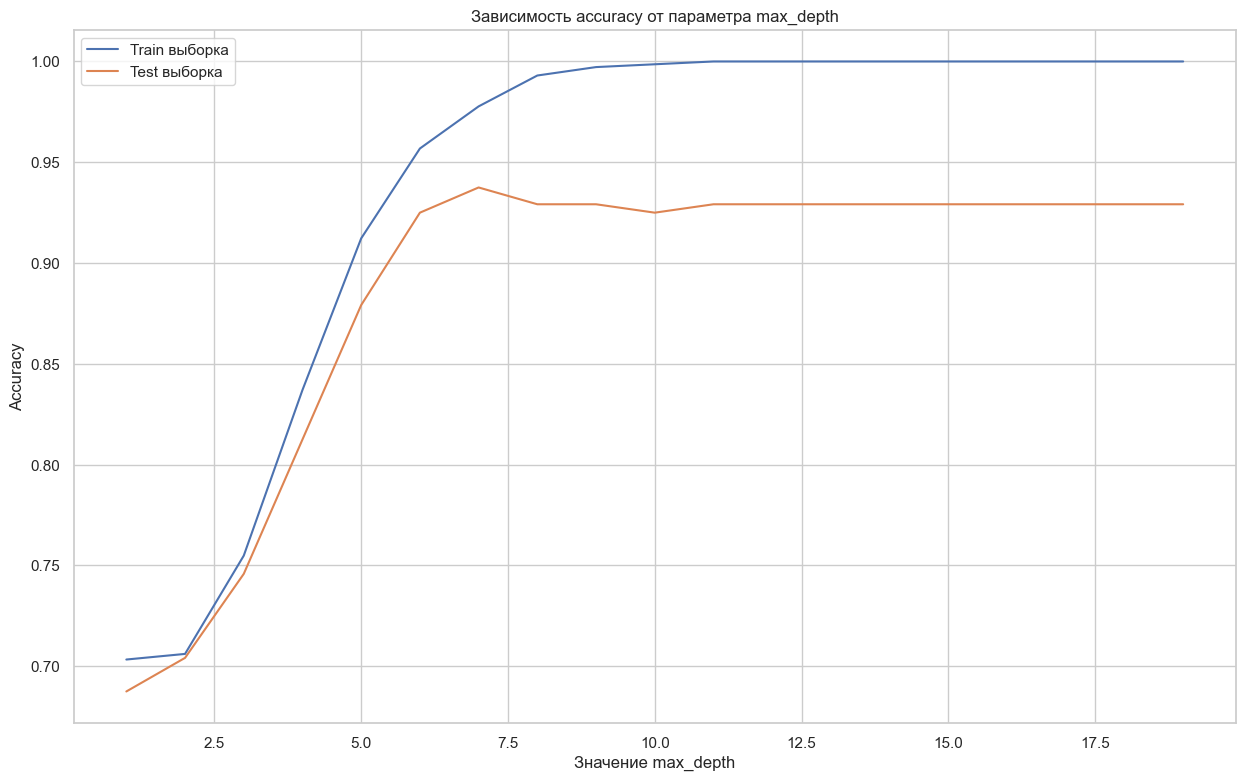

In [57]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from hw5code import DecisionTree


def get_samples_transformed_by_label_encoder(url, target_index, values_positive):
    data = pd.read_csv(url, header=None)
    
    y = (data[target_index] == values_positive[0])
    for target in values_positive:
        y |= (data[target_index] == target)
    y *= 1
    X = data.drop(columns=[target_index])
    X_transformed = pd.DataFrame(
        {index: LabelEncoder().fit_transform(X[index]) for index in X.columns}
    )
    return X_transformed.to_numpy(), y.to_numpy()

param = {
    'url': 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
    'target_index': 9,
    'values_positive': ['positive']
}

X, y = get_samples_transformed_by_label_encoder(**param)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/4, random_state=42
)

for param in ['max_depth']:
    train_accuracy = []
    test_accuracy = []
    max_i = 20

    for i in range(1, max_i):
        decision_tree = DecisionTree(["categorical"] * X_train.shape[1], **{param: i})
        decision_tree.fit(X_train, y_train)
        train_accuracy.append(np.sum((decision_tree.predict(X_train) == y_train) * 1) / y_train.shape[0])
        test_accuracy.append(np.sum((decision_tree.predict(X_test) == y_test) * 1) / y_test.shape[0])
    plt.figure(figsize=(15, 9))
    plt.plot(list(range(1, max_i)), train_accuracy, label='Train выборка')
    plt.plot(list(range(1, max_i)), test_accuracy, label='Test выборка')
    plt.title(f'Зависимость accuracy от параметра {param}')
    plt.xlabel(f'Значение {param}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [51]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from hw5code import DecisionTree

urls = {
    'mushrooms': 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
    'tic-tac-toe': 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
    'cars': 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
    'nursery': 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
}

params = [
    { 'url': urls['mushrooms'], 'target_index': 0, 'values_positive': ['e'] },
    { 'url': urls['tic-tac-toe'], 'target_index': 9, 'values_positive': ['positive']},
    { 'url': urls['cars'], 'target_index': 6, 'values_positive': ['good', 'vgood']},
    { 'url': urls['nursery'], 'target_index': 8, 'values_positive': ['very_recom', 'priority', 'spec_prior']},
]

result = pd.DataFrame()

def get_samples_transformed(url, target_index, values_positive):
    data = pd.read_csv(url, header=None)

    y = (data[target_index] == values_positive[0])

    for target in values_positive:
        y |= (data[target_index] == target)

    y *= 1
    X = data.drop(columns=[target_index])
    X_transformed = pd.DataFrame(
        {index: LabelEncoder().fit_transform(X[index]) for index in X.columns}
    )
    return X_transformed.to_numpy(), y.to_numpy()

rows = []
dt_real = []
dt_cat = []
dt_real_ohe = []
dtc = []

for param in params:
    X, y = get_samples_transformed(**param)
    rows.append(param['url'].split('/')[-1])
    
    my_dt = DecisionTree(["real"] * X.shape[1])
    dt_real.append(np.mean(cross_val_score(my_dt, X, y, cv=10, scoring=make_scorer(accuracy_score))))
    
    my_dt = DecisionTree(["categorical"] * X.shape[1])
    dt_cat.append(np.mean(cross_val_score(my_dt, X, y, cv=10, scoring=make_scorer(accuracy_score))))
    
    ohe = OneHotEncoder(sparse=False)
    X_ohe = ohe.fit_transform(X)
    my_dt = DecisionTree(["real"] * X_ohe.shape[1])
    dt_real_ohe.append(np.mean(cross_val_score(my_dt, X_ohe, y, cv=10, scoring=make_scorer(accuracy_score))))
    
    dt = DecisionTreeClassifier()
    dtc.append(np.mean(cross_val_score(dt, X, y, cv=10, scoring=make_scorer(accuracy_score))))

result = pd.DataFrame(
    {
        'DecisionTree Feature_type=real': dt_real,
        'DecisionTree Feature_type=categorical': dt_cat,
        'DecisionTree Feature_type=real + OneHotEncoding': dt_real_ohe,
        'DecisionTreeClassifier': dtc,
    },
    index = rows
) 
result

,DecisionTree Feature_type=real,DecisionTree Feature_type=categorical,DecisionTree Feature_type=real + OneHotEncoding,DecisionTreeClassifier
agaricus-lepiota.data,0.999261,1.000000,0.999631,0.961123
tic-tac-toe.data,0.467533,0.541458,0.543575,0.756064
car.data,0.942647,0.967546,0.919495,0.943285
nursery.data,0.999691,0.999846,0.999537,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
Для каждого набора данных лучше подходит свой алгоритм.  Для tic-tac-toe не всегда плохое качество, есть такие наборы данных, что качество близко или равняется 1. Следовательно все зависит от самой выборки, так решающее дерево строит для него путь к классу. Нужно сбалансировано подбирать train выборку.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [52]:
Норм

NameError: name 'Норм' is not defined